In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import loadTDT as tdt
from scipy import signal
from scipy.signal import detrend
from scipy.signal import resample
from scipy.signal import medfilt
from scipy.signal import butter
from scipy.signal import filtfilt
from statsmodels import robust
from scipy import ndimage, misc
from scipy.ndimage import gaussian_filter1d
import pims
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
from scipy.stats import entropy
sns.set_context("paper")

## All advanced analysis for behavioral analysis of opto cohorts
Data can be downloaded from https://figshare.com/articles/dataset/Defeat_Behavior_during_Optogenetic_Manipulation/20147126

In [26]:
groups={'closed-loop':[743,748,742,735,411,403,412,420,648,649,640,642,109,111,112,105],
        'no opsin control':[750,752,410,401,635,419,627,628,629,630,101,102,104,106],
        'open-loop':[741,744,734,409,413,402,418,654,650,651,108,103,113,110]}
ppal=['yellowgreen','hotpink','grey']
pord=['closed-loop','open-loop','no opsin control']

# recording frame rate
FS=120

In [3]:
import pickle
alldat = pickle.load( open( "opto_fight_open.p", "rb" ) )

Quantify and visualize stimulation relative to behavior

In [5]:
def get_trigger(x,thresh,lag):
    t=np.where(x>thresh)[0]
    t=[t_i for t_i in t if np.sum(x[t_i-lag:t_i]>thresh)==0]
    return np.array(t)
    

In [14]:
stimlens=[]
totalstims=[]
for g in groups:
    for m in groups[g]:
        for d in range(1,11):
            k= (m,d)
            if k not in alldat or 'laser_on' not in alldat[k]:
                continue
            s=alldat[k]['laser_on']
            totalstims.append(float(np.sum(s>1))/len(s))
            ons=get_trigger(s,1,20)
            for o in ons:
                bigger=get_trigger(medfilt(-1*s[o:o+500]+5,21),1,20)
                if len(bigger):
                    stimlens.append(bigger[0]/120)

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


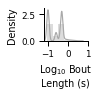

In [15]:
plt.figure(figsize=(0.8,0.6))
sns.distplot(np.log10(stimlens),bins=10,color='darkgrey')
plt.xlim(-1.2,1)
sns.despine()
plt.xlabel('Log$_{10}$ Bout\nLength (s)')
plt.ylabel('Density')
plt.show()

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


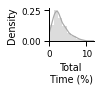

In [16]:
plt.figure(figsize=(0.8,0.6))
sns.distplot(100*np.array(totalstims),bins=10,color='darkgrey')
plt.xlim(0,12)
sns.despine()
plt.xlabel('Total\nTime (%)')
plt.ylabel('Density')
plt.show()

Load random forest models found at https://figshare.com/articles/dataset/Defeat_Recording_Data/20102681

In [18]:
rfs = pickle.load(open('rfs_2101_new_behaviors.p','rb'),encoding='latin')
rfs_old = pickle.load(open('rfs_2101_old_behaviors.p','rb'),encoding='latin')
rf_scores = {}
for k in alldat.keys():
    if k in rf_scores:
        continue
    rf_scores[k]={}
    X=alldat[k]['extracted_features']
    for b,(rf,c)in rfs.items():
        pred = rf.predict_proba(X)
        rf_scores[k][b]=medfilt(pred.T[0],11)<c
    for b,(rf,c)in rfs_old.items():
        if b == 'fightback':
            continue
        pred = rf.predict_proba(X)
        rf_scores[k][b]=medfilt(pred.T[0],11)<c

(3.231666666666669, 316.7683333333333, -0.38, 1.3800000000000001)

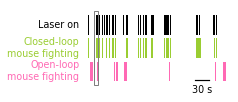

In [27]:
import matplotlib.patches as patches
fig,ax=plt.subplots(1,1,figsize=(2.7,1.5))
d=7
k0=(649,d)
k1=(650,d)
test0=rf_scores[k0]['fightback']
test1=rf_scores[k1]['fightback']
t=np.arange(len(test0))/FS
laseron=alldat[k0]['laser_on']>1
for tick in t[np.where(laseron)[0]]:
    plt.plot([tick,tick],[0.8,1.2],color='k',linewidth=1)
    
for tick in t[np.where(test0)[0]]:
    plt.plot([tick,tick],[0.7,0.3],color=ppal[0],linewidth=1)
    
for tick in t[np.where(test1)[0]]:
    plt.plot([tick,tick],[-0.2,0.2],color=ppal[1],linewidth=1)
plt.text(0,1,'Laser on',va='center',ha='right')
plt.text(0,0.5,'Closed-loop\nmouse fighting',va='center',ha='right',color=ppal[0])
plt.text(0,0,'Open-loop\nmouse fighting',va='center',ha='right',color=ppal[1])

rect = patches.Rectangle((30, -0.3), 10,1.6, linewidth=1, edgecolor='grey', facecolor='none',
                        zorder=100)

ax.add_patch(rect)
plt.plot([60*4,60*4+30],[-0.2,-0.2],color='k')
plt.text(60*4+15,-0.3,'30 s',va='top',ha='center',color='k')

plt.axis('off')

(30.0, 40.0)

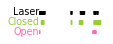

In [33]:
plt.figure(figsize=(1.2,0.4))
d=7
k0=(649,d)
k1=(650,d)
test0=rf_scores[k0]['fightback']
test1=rf_scores[k1]['fightback']
t=np.arange(len(test0))/120
plt.scatter(t[np.where(test0)[0]],np.ones(sum(test0))-0.5,color=ppal[0],marker='|')
plt.scatter(t[np.where(test1)[0]],np.ones(sum(test1))-1,color=ppal[1],marker='|')
laseron=alldat[k0]['laser_on']>1
plt.scatter(t[np.where(laseron)[0]],np.ones(np.sum(laseron)),marker='|',color='k')
plt.text(30,1,'Laser',va='center',ha='right')
plt.text(30,0.5,'Closed',va='center',ha='right',color=ppal[0])
plt.text(30,0,'Open',va='center',ha='right',color=ppal[1])
plt.axis('off')
plt.xlim(30,40)

Analyze behavior change from early to late defeat

In [36]:
rf_totals = {'m':[],'d':[],'t':[],'b':[],'g':[]}
fight_check = {'m':[],'d':[],'F':[],'T':[],'f':[],'a':[],'R':[],'r':[]}
for i,m in enumerate(set([k[0] for k in alldat.keys()])):
    g=None
    for g_t,mlist in groups.items():
        if m in mlist:
            g=g_t
            break
    for d in range(1,11):
        if (m,d) not in rf_scores:
            continue
        rf=rf_scores[(m,d)]
        
        # EARLY
        for b,l in rf.items():
            t=l
            rf_totals['b'].append(b)
            rf_totals['m'].append(int(m))
            rf_totals['d'].append(d)
            rf_totals['g'].append(g)
            rf_totals['t'].append(np.sum(t)/len(t))

        a=rf['attack']
        b=np.logical_and(a,rf['fightback'])
        rf_totals['b'].append('fightWhenAttacked')
        rf_totals['m'].append(int(m))
        rf_totals['d'].append(d)
        rf_totals['g'].append(g)
        rf_totals['t'].append(np.sum(b)/np.sum(a))
        
        
        a=rf['attack']
        b=np.logical_and(a,rf['runaway'])
        rf_totals['b'].append('fleeWhenAttacked')
        rf_totals['m'].append(int(m))
        rf_totals['d'].append(d)
        rf_totals['g'].append(g)
        rf_totals['t'].append(np.sum(b)/np.sum(a))


        a=rf['fightback']
        b=np.logical_and(a,np.logical_not(rf['attack']))
        rf_totals['b'].append('notAttackedWhenFight')
        rf_totals['m'].append(int(m))
        rf_totals['d'].append(d)
        rf_totals['g'].append(g)
        rf_totals['t'].append(np.sum(b)/np.sum(a))

        a=np.logical_not(rf['attack'])
        b=np.logical_and(a,rf['fightback'])
        rf_totals['b'].append('fightWhenNotAttacked')
        rf_totals['m'].append(int(m))
        rf_totals['g'].append(g)
        rf_totals['d'].append(d)
        rf_totals['t'].append(np.sum(b)/np.sum(a))

        a=np.logical_not(rf['runaway'])
        b=np.logical_and(a,rf['fightback'])
        rf_totals['b'].append('fightWhenNotFlee')
        rf_totals['m'].append(int(m))
        rf_totals['g'].append(g)
        rf_totals['d'].append(d)
        rf_totals['t'].append(np.sum(b)/np.sum(a))
        
        a=rf['runaway']
        b=rf['fightback']
        rf_totals['b'].append('fightToFleeRatio')
        rf_totals['m'].append(int(m))
        rf_totals['g'].append(g)
        rf_totals['d'].append(d)
        rf_totals['t'].append(np.sum(b)/np.sum(a))


rf_df = pd.DataFrame(rf_totals)
rf_df['p']=rf_df['t']*100

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars


In [37]:
fight_increase_df={'m':[],'earlylate':[],'t':[],'group':[]}
for m,d in rf_df.query('b=="fightWhenAttacked"').groupby('m'):
    fight_increase_df['m'].append(m)
    fight_increase_df['earlylate'].append('early')
    fight_increase_df['t'].append(d.query('d<=2').p.mean())
    fight_increase_df['group'].append(d.g.values[0])
    fight_increase_df['m'].append(m)
    fight_increase_df['earlylate'].append('late')
    fight_increase_df['t'].append(d.query('d>=9').p.mean())
    fight_increase_df['group'].append(d.g.values[0])
fight_increase_df=pd.DataFrame(fight_increase_df)

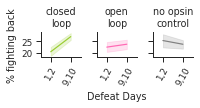

In [107]:
sns.set_style('ticks')
gs=['closed-loop','open-loop','no opsin control']
g=sns.relplot(data=fight_increase_df,x='earlylate',y='t',hue='group',
              ci=68,kind='line',
            palette=list(np.array(ppal)[[0,1,2]]),
             hue_order=gs,
            col_order=gs,
            sort=False,col='group',
             height=1.6,aspect=0.6,legend=False)
plt.xlabel('Before or After Day 5')
plt.title('Fleeing while attacked')
plt.ylabel('% of Attack Time Fighting')
for l,a in zip(['closed\nloop','open\nloop','no opsin\ncontrol'],g.axes[0]):
    a.set_title(l)
    a.set_xlim(-0.5,1.5)
    a.set_xticklabels(['1,2','9,10'],rotation=60)
    a.set_xlabel('')
g.axes[0][1].set_xlabel('Defeat Days')
sns.despine(ax=g.axes[0][2],left=False)
g.axes[0][0].set_ylabel('% fighting back')
plt.tight_layout()


In [51]:
import statsmodels
from scipy.stats import ttest_rel

t1=ttest_rel(pd.DataFrame(fight_increase_df).query('group=="closed-loop" and earlylate=="early"').t,
         pd.DataFrame(fight_increase_df).query('group=="closed-loop" and earlylate=="late"').t)
t2=ttest_rel(pd.DataFrame(fight_increase_df).query('group=="open-loop" and earlylate=="early"').t,
             pd.DataFrame(fight_increase_df).query('group=="open-loop" and earlylate=="late"').t)
t3=ttest_rel(pd.DataFrame(fight_increase_df).query('group=="no opsin control" and earlylate=="early"').t,
         pd.DataFrame(fight_increase_df).query('group=="no opsin control" and earlylate=="late"').t)
(t1,t2,t3)

(Ttest_relResult(statistic=-2.7707023363402006, pvalue=0.014278617050662),
 Ttest_relResult(statistic=-0.3824794442864293, pvalue=0.7082858750599406),
 Ttest_relResult(statistic=0.41443205354717755, pvalue=0.6853146592689537))

Analyze behavior as embedded into t-SNE space.
Maps created using obserational cohort.
t-SNE projection model can be downloaded from https://figshare.com/articles/dataset/Defeat_Recording_Data/20102681

In [56]:
## t-SNE
saved=pickle.load(open('tsne_2101.p','rb'))
mlp2=saved['projection']
labeled_map=saved['map']

In [57]:
## t-SNE parameters

# average distance between mice
tsne_dists=[229.70494978266953,
 245.55505578548951,
 245.12842340146145,
 166.58055751288933,
 149.51097837985458,
 250.90124233870606,
 226.49122360206243,
 141.3280762786305,
 96.60278218737608,
 128.60567565443952,
 93.26928011218547,
 175.86329471200276,
 89.84951112059038,
 90.04663779430373,
 203.50069251536658,
 57.43254248517057,
 123.0666217373827,
 92.19272510334693]

# dimensions of 2D histogram over t-SNE space
map_shape=(50,50)

# location in 50,50 histogram where the cluster peaks are
peakx=[5, 6, 10, 11, 15, 18, 18, 19, 21, 25, 26, 27, 30, 31, 32, 36, 39, 39]
peaky=[24, 16, 13, 36, 26, 6, 15, 24, 40, 19, 29, 13, 35, 41, 8, 27, 12, 22]

# Mapping from continuous 2D t-SNE space to histogram boundaries originally defined by photometry study
xe,ye=(np.array([-53.31824247, -51.02838956, -48.73853665, -46.44868374,
        -44.15883083, -41.86897791, -39.579125  , -37.28927209,
        -34.99941918, -32.70956627, -30.41971336, -28.12986044,
        -25.84000753, -23.55015462, -21.26030171, -18.9704488 ,
        -16.68059589, -14.39074297, -12.10089006,  -9.81103715,
         -7.52118424,  -5.23133133,  -2.94147842,  -0.6516255 ,
          1.63822741,   3.92808032,   6.21793323,   8.50778614,
         10.79763905,  13.08749197,  15.37734488,  17.66719779,
         19.9570507 ,  22.24690361,  24.53675652,  26.82660944,
         29.11646235,  31.40631526,  33.69616817,  35.98602108,
         38.27587399,  40.56572691,  42.85557982,  45.14543273,
         47.43528564,  49.72513855,  52.01499147,  54.30484438,
         56.59469729,  58.8845502 ,  61.17440311]),
 np.array([-49.13876281, -47.0439975 , -44.9492322 , -42.85446689,
        -40.75970159, -38.66493628, -36.57017098, -34.47540567,
        -32.38064037, -30.28587506, -28.19110976, -26.09634445,
        -24.00157915, -21.90681384, -19.81204854, -17.71728323,
        -15.62251793, -13.52775262, -11.43298732,  -9.33822201,
         -7.24345671,  -5.1486914 ,  -3.0539261 ,  -0.95916079,
          1.13560451,   3.23036982,   5.32513512,   7.41990043,
          9.51466573,  11.60943104,  13.70419634,  15.79896165,
         17.89372695,  19.98849226,  22.08325756,  24.17802287,
         26.27278817,  28.36755348,  30.46231878,  32.55708409,
         34.6518494 ,  36.7466147 ,  38.84138001,  40.93614531,
         43.03091062,  45.12567592,  47.22044123,  49.31520653,
         51.40997184,  53.50473714,  55.59950245]))

In [54]:
embeddings={}
for test_key in alldat.keys():
    test_X = alldat[test_key]['extracted_features']
    embedded_mlp = mlp2.predict(test_X)
    embeddings[test_key]=embedded_mlp

In [58]:

xmin=min(xe)
xmax=max(xe)
ymin=min(ye)
ymax=max(ye)
labels={}
for k,e in embeddings.items():

    def to_coords(xy):
        
        x = (xy[0] - xmin) / (xmax - xmin) * map_shape[0]
        y = (xy[1] - ymin) / (ymax - ymin) * map_shape[1]
        if x >= map_shape[0]:
            x = map_shape[0]-1
        if y >= map_shape[1]:
            y = map_shape[1]-1
        if x < 0:
            x=0
        if y < 0:
            y=0
        return int(x), int(y)
    labels[k] = np.array([labeled_map[to_coords(point)] for point in e])

In [60]:
def heatmap(data, axlims=None, bins=100, normed=True, sigma=0.0):
    from scipy.ndimage.filters import gaussian_filter
    # Initial histogram
    heatmap, xedges, yedges = np.histogram2d(data[:,0], data[:, 1],
            bins=bins, range=axlims, normed=normed)
    # Convolve with Gaussian
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    return heatmap,xedges,yedges

hists = {}
for test_key in embeddings:
    embedded_mlp=embeddings[test_key]
    z,_,_ = heatmap(embedded_mlp, bins=(xe,ye), sigma=1.5)
    hists[test_key]=z/z.sum()

In [62]:
hists_stim={}
for g in groups:
    for m in groups[g]:
        for d in range(1,11):
            k= (m,d)
            if k not in alldat or 'laser_on' not in alldat[k]:
                continue
            s=alldat[k]['laser_on']>1
            embedded_mlp=embeddings[k]
            if len(s)!=len(embedded_mlp):
                continue
            z,_,_ = heatmap(embedded_mlp[s], bins=(xe,ye), sigma=1.5)
            z2,_,_ = heatmap(embedded_mlp, bins=(xe,ye), sigma=1.5)
            hists_stim[k]=(z/z.sum())

Align stimulation to behavior in t-SNE space

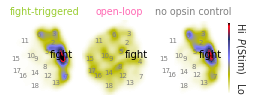

In [103]:

sns.set_style('dark')
o2title={'closed-loop':'fight-triggered','open-loop':'open-loop','no opsin control':'no opsin control'}
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(4,1.5))
for i,g in enumerate(pord):

    resilient_map=np.zeros(hists[(420,1)].shape)
    for m in groups[g]:

        for d in range(1,11):
            if (m,d) in hists_stim:
                resilient_map += hists_stim[(m,d)]/np.sum(hists[(m,d)])
    resilient_map=resilient_map/resilient_map.sum()
    im=axs[i].imshow(resilient_map.T,origin='lower',cmap='gist_stern_r',vmin=0,vmax=0.005)
    axs[i].axis('off')
    axs[i].set_title(o2title[g],color=ppal[i])
    for j in np.unique((labeled_map).flatten()):
        x=peakx[int(j)-1]
        y=peaky[int(j)-1]
        if np.where(np.argsort(tsne_dists)==int(j)-1)[0][0]+1 != 1:
            axs[i].text(x,y,np.where(np.argsort(tsne_dists)==int(j)-1)[0][0]+1,size=7,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color='grey')
        else:
            axs[i].text(x,y,'fight',size=10,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color='black')
cbar=fig.colorbar(im,fraction=0.048,orientation='vertical',pad=-0.04)
cbar.set_ticks([])
fig.subplots_adjust(wspace=0, hspace=0)
cbar.set_label('Hi  $P$(Stim)   Lo',rotation=-90,va='bottom')

plt.show()

Assess differences in behavior across groups and observational vs optogenetic manipulation experiments

In [74]:
ms = []
ds = []
ls = []
ts = []
gs = []

for g in groups:
    for m in groups[g]:
        for d in range(1,11):
            if (m,d) in labels.keys():
                for l in range(1,19):
                    ls.append('t-SNE %d'%l)
                    ts.append(np.sum(labels[(m,d)]==l)/len(labels[(m,d)])*100)
                    ms.append(m)
                    ds.append(d)
                    gs.append(g)

In [78]:
df=pd.DataFrame({'m':ms,'d':ds,'c':ls,'t':ts,'group':gs})
test=pd.pivot_table(df.query('group in %s'%pord),values='t',index=['m','group'],columns='c')
testrb=np.array([i[1] for i in test.index])

In [86]:
from sklearn.feature_selection import chi2
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

PiBr = LinearSegmentedColormap.from_list(
        "Custom", ['hotpink','white','gray'], N=40)

YGBr = LinearSegmentedColormap.from_list(
        "Custom", ['yellowgreen','white','gray'], N=40)

Download pre-calculated t-SNE behavior maps from other cohorts (seen below how these individual mean behavior maps are generated for the presently analyzed closed-loop.
Maps file can be found at https://figshare.com/articles/dataset/Defeat_Behavior_during_Optogenetic_Manipulation/20147126

In [87]:
mouse_maps=pickle.load( open( "opto_maps.p", "rb" ) )

In [88]:
diffmap=mouse_maps['resilient_fp']-mouse_maps['susceptible_fp']

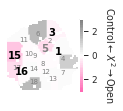

In [90]:
sns.set_context("paper")
sns.set_style("dark")
plt.figure(figsize=(1.8,1.6))
z=np.zeros(labeled_map.shape)
for i in np.unique(labeled_map.flatten()):
    if i in range(1,19):
        x=peakx[int(i)-1]
        y=peaky[int(i)-1]
        if np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1 in [1,3,15,16]:
            plt.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,
                     size=10,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color='k', weight='bold')
        elif np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1==5:
            plt.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,
                     size=10,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color='grey',weight='bold')
        else:
            plt.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,
                     size=7,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color='grey')
        val=chi[int(i)-1]*scale[int(i)-1]
        z[np.where(labeled_map.astype(int)==int(i))[0],np.where(labeled_map.astype(int)==int(i))[1]]=val


mx=np.ma.masked_array(z, np.abs(diffmap)<np.percentile(np.abs(diffmap),20))
im=plt.imshow(mx.T,origin='lower',vmin=-3,vmax=3,
            cmap=PiBr)


cbar=plt.colorbar(im,fraction=0.048,orientation='vertical',pad=0.02)
cbar.set_ticks([2,0,-2])
cbar.set_ticklabels([2,0,2])
cbar.set_label(r'Control$\leftarrow$$X^2$$\rightarrow$Open',rotation=-90,va='bottom')
plt.axis('off')
plt.tight_layout()
plt.show()

In [91]:
chi,p=chi2(test.iloc[testrb!="open-loop",:][['t-SNE %d'%(i) for i in range(1,19)]],
           testrb[testrb!="open-loop"])

scale=np.array([1-2*((np.mean(test.loc[testrb=='no opsin control','t-SNE %d'%(i)])-np.mean(test.loc[testrb=='closed-loop','t-SNE %d'%(i)]))<0) for i in range(1,19)])


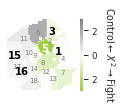

In [93]:
sns.set_context("paper")
sns.set_style("dark")
plt.figure(figsize=(1.8,1.6))
z=np.zeros(labeled_map.shape)
for i in np.unique(labeled_map.flatten()):
    if i in range(1,19):
        x=peakx[int(i)-1]
        y=peaky[int(i)-1]
        if np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1 in [1,3,15,16]:
            plt.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,
                     size=10,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color='k', weight='bold')
        elif np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1==5:
            plt.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,
                     size=10,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color='white',weight='bold')
        else:
            plt.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,
                     size=7,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color='grey')
        val=chi[int(i)-1]*scale[int(i)-1]
        z[np.where(labeled_map.astype(int)==int(i))[0],np.where(labeled_map.astype(int)==int(i))[1]]=val


mx=np.ma.masked_array(z, np.abs(diffmap)<np.percentile(np.abs(diffmap),20))
im=plt.imshow(mx.T,origin='lower',vmin=-3,vmax=3,
            cmap=YGBr)


cbar=plt.colorbar(im,fraction=0.048,orientation='vertical',pad=0.02)
cbar.set_ticks([2,0,-2])
cbar.set_ticklabels([2,0,2])
cbar.set_label(r'Control$\leftarrow$$X^2$$\rightarrow$Fight',rotation=-90,va='bottom')
plt.axis('off')
plt.tight_layout()

plt.show()

In [94]:
for g in groups:
    for m in groups[g]:
        sub_m=np.zeros((50,50))
        for d in range(1,11):
            if (m,d) in hists:
                sub_m += hists[(m,d)]
        if sub_m.sum()!=0:
            mouse_maps[(m,g)]=sub_m/sub_m.sum()

In [104]:
from scipy.stats import entropy
def KL(a, b):
    import warnings
    warnings.filterwarnings("ignore")
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(np.logical_and(a != 0,b != 0) , a * np.log2(a / b), 0))

In [105]:
indi_map_sim={'g':[],
             'm':[],
             'diff':[]}
for k,m in mouse_maps.items():
    if len(k)==1:
        continue
    diff=np.linalg.norm(m.flatten()-
              mouse_maps['resilient_fp'].flatten(),axis=0)-np.linalg.norm(m.flatten()-
              mouse_maps['susceptible_fp'].flatten(),axis=0)
    k1=KL(m.flatten(),
            mouse_maps['resilient_fp'].flatten())
    k2=KL(m.flatten(),mouse_maps['susceptible_fp'].flatten())
    k3=KL(m.flatten(),np.mean([mouse_maps['susceptible_fp'].flatten(),
                              mouse_maps['resilient_fp'].flatten()],axis=0))
    diff=(k1-k2)/k3
    indi_map_sim['g'].append(k[1])
    indi_map_sim['m'].append(k[0])
    indi_map_sim['diff'].append(diff)

open-loop -2.7820728144272326 0.015554248334185635
closed-loop -2.923748943841615 0.0104774529777727
attack-offset-stim 1.0750843900316782 0.31799057169969286
attack-inhibition 3.2832079827637024 0.007292121699710555
(array([ True,  True, False,  True]), array([0.020739  , 0.020739  , 0.31799057, 0.020739  ]))


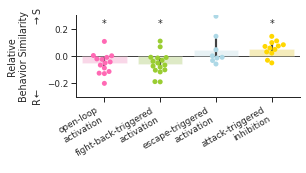

In [108]:
sns.set_style('ticks')
my_ord=['open-loop','closed-loop','attack-offset-stim','attack-inhibition']
my_pal=['hotpink','yellowgreen','lightblue','gold']
test_df=pd.DataFrame(indi_map_sim)
plt.figure(figsize=(4,1.5))
sns.swarmplot(data=test_df,x='g',y='diff',
              order=my_ord,
              palette=my_pal)
sns.barplot(data=test_df,x='g',y='diff',
           palette=my_pal,alpha=0.3,
           order=my_ord)
plt.xticks([0,1,2,3],
           ['open-loop\nactivation','fight-back-triggered\nactivation','escape-triggered\nactivation','attack-triggered\ninhibition'],
           rotation=30,ha='right')
plt.xlabel('')
plt.ylabel('Relative\nBehavior Similarity\n'+r'R$\leftarrow$                    $\rightarrow$S')
plt.axhline(y=0,color='k',zorder=-1,linewidth=0.75)
plt.ylim(-0.3,0.3)
sns.despine()
for i in [0,1,3]:
    plt.text(i,0.24,'*',va='center',ha='center')

from scipy.stats import ttest_1samp,ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from itertools import combinations
ps= []
for g in my_ord:
    t,p=ttest_1samp(test_df.query('g=="%s"'%g)['diff'],0)
    print(g,t,p)
    ps.append(p)
print(fdrcorrection(ps))